In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

## Alexandre Dumas
### The Count of Monte Cristo

In [2]:
BODY_START = 314
BODY_END = 60662
CHAP_PAT = r'^\s*(?:VOLUME|Chapter).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'data/The_Count_of Monte_Cristo.txt'

In [3]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [4]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [5]:
lines[:10]

['VOLUME ONE\n',
 '\n',
 '\n',
 '\n',
 'Chapter 1. Marseilles—The Arrival\n',
 '\n',
 'On the 24th of February, 1815, the look-out at Notre-Dame de la Garde\n',
 'signalled the three-master, the Pharaon from Smyrna, Trieste, and\n',
 'Naples.\n',
 '\n']

In [6]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [7]:
df.head()

,line_str
line_id,
0,VOLUME ONE\n
1,\n
2,\n
3,\n
4,Chapter 1. Marseilles—The Arrival\n


In [8]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('tagsets')
# nltk.download('wordnet')

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [11]:
cfg = dict(
    src_file = src_file,
    body_start = 314,
    body_end = 60662,
    chap_pat = r'^\s*(?:VOLUME|Chapter).*$'
)
MC_K, MC_V = text_to_tokens(**cfg)

In [12]:
MC_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0          NNP    VOLUME     0    0   volume   
                           1           CD       ONE     0    0      one   
1        0        0        0           NN   Chapter     0    0  chapter   
                           1           CD         1     0    1      NaN   
                           2            .         .     1    0      NaN   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0            15194  
                           1             9628  
1        0        0        0             2273  
                           1               -1  
                           2               -1

In [13]:
MC_K = MC_K.loc[MC_K.term_id >= 0]

In [14]:
MC_K.head()

pos   token_str  punc  num    term_str  \
chap_num para_num sent_num token_num                                           
0        0        0        0          NNP      VOLUME     0    0      volume   
                           1           CD         ONE     0    0         one   
1        0        0        0           NN     Chapter     0    0     chapter   
                  1        0          NNS  Marseilles     0    0  marseilles   
                           2           DT         The     0    0         the   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0            15194  
                           1             9628  
1        0        0        0             2273  
                  1        0             8620  
                           2            14076

In [15]:
MC_V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,a,9398,0.020182,a,1
1,aaron,1,0.000002,aaron,0
2,abandon,13,0.000028,abandon,0
3,abandoned,17,0.000037,abandon,0
4,abandoning,2,0.000004,abandon,0


In [16]:
WORDS = (MC_K.punc == 0) & (MC_K.num == 0) & MC_K.term_id.isin(MC_V[MC_V.stop==0].index)

In [17]:
BOW = MC_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [18]:
DTM = BOW.unstack().fillna(0)

In [19]:
DTM.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,15703,15704,15705,15706,15707,15708,15709,15710,15711,15712
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
alpha = .000001
alpha_sum = alpha * MC_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [21]:
N_docs = DTM.shape[0]
MC_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / MC_V[MC_V.stop==0]['df'])

In [22]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,15703,15704,15705,15706,15707,15708,15709,15710,15711,15712
chap_num,,,,,,,,,,,,,,,,,,,,,
0,3.438355e-06,1.659847e-06,1.500138e-06,2.942253e-06,3.438355e-06,3.438355e-06,3.438355e-06,3.438355e-06,3.438355e-06,3.438355e-06,...,2.446150e-06,3.438355e-06,3.438355e-06,3.438355e-06,1.226021e-06,3.438355e-06,1.259316e-06,2.942253e-06,3.438355e-06,2.942253e-06
1,4.682881e-09,2.260635e-09,2.043118e-09,4.007212e-09,4.682881e-09,4.682881e-09,4.682881e-09,4.682881e-09,4.682881e-09,4.682881e-09,...,3.331544e-09,4.682881e-09,4.682881e-09,4.682881e-09,1.669783e-09,4.682881e-09,1.715130e-09,4.007212e-09,4.682881e-09,4.007212e-09
2,5.833877e-09,2.816272e-09,2.545292e-09,4.992137e-09,5.833877e-09,5.833877e-09,5.833877e-09,5.833877e-09,5.833877e-09,5.833877e-09,...,4.150397e-09,5.833877e-09,5.833877e-09,5.833877e-09,2.080196e-09,5.833877e-09,2.136689e-09,4.992137e-09,5.833877e-09,4.992137e-09
3,3.750367e-09,1.810469e-09,1.636267e-09,3.209246e-09,3.750367e-09,3.750367e-09,3.750367e-09,3.750367e-09,3.750367e-09,3.750367e-09,...,2.668125e-09,3.750367e-09,3.750367e-09,3.750367e-09,1.337275e-09,3.750367e-09,1.373592e-09,3.209246e-09,3.750367e-09,3.209246e-09
4,6.544509e-09,3.159325e-09,2.855337e-09,5.600235e-09,6.544509e-09,6.544509e-09,6.544509e-09,6.544509e-09,6.544509e-09,6.544509e-09,...,4.655962e-09,6.544509e-09,6.544509e-09,6.544509e-09,2.333587e-09,6.544509e-09,2.396962e-09,5.600235e-09,6.544509e-09,5.600235e-09


In [23]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [24]:
TFTH.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,15703,15704,15705,15706,15707,15708,15709,15710,15711,15712
chap_num,,,,,,,,,,,,,,,,,,,,,
0,4.696417e-09,3.724139e-08,5.069830e-08,3.423942e-09,2.297735e-09,2.436552e-09,2.807387e-09,2.807387e-09,2.239810e-09,2.250527e-09,...,8.521851e-09,3.374190e-09,1.870451e-09,5.284758e-09,9.385758e-08,2.976052e-09,1.715024e-07,1.188028e-08,2.364955e-09,6.667363e-09
1,6.396303e-12,5.072105e-11,6.904874e-11,4.663250e-12,3.129409e-12,3.318471e-12,3.823531e-12,3.823531e-12,3.050518e-12,3.065114e-12,...,1.160637e-11,4.595490e-12,2.547467e-12,7.197596e-12,1.278297e-10,4.053246e-12,2.335783e-10,1.618039e-11,3.220960e-12,9.080641e-12
2,7.968437e-12,6.318768e-11,8.602010e-11,5.809421e-12,3.898580e-12,4.134111e-12,4.763309e-12,4.763309e-12,3.800299e-12,3.818482e-12,...,1.445907e-11,5.725007e-12,3.173604e-12,8.966679e-12,1.592487e-10,5.049485e-12,2.909890e-10,2.015734e-11,4.012633e-12,1.131255e-11
3,5.122591e-12,4.062084e-11,5.529890e-11,3.734645e-12,2.506242e-12,2.657655e-12,3.062142e-12,3.062142e-12,2.443061e-12,2.454750e-12,...,9.295163e-12,3.680379e-12,2.040184e-12,5.764321e-12,1.023746e-10,3.246113e-12,1.870653e-10,1.295835e-11,2.579562e-12,7.272390e-12
4,8.939082e-12,7.088465e-11,9.649831e-11,6.517074e-12,4.373470e-12,4.637692e-12,5.343534e-12,5.343534e-12,4.263218e-12,4.283616e-12,...,1.622035e-11,6.422377e-12,3.560185e-12,1.005892e-11,1.786470e-10,5.664569e-12,3.264348e-10,2.261273e-11,4.501417e-12,1.269055e-11


In [25]:
MC_V['tf_sum'] = TF.sum()
MC_V['tf_mean'] = TF.mean()
MC_V['tf_max'] = TF.max()
MC_V['tfidf_sum'] = TFIDF.sum()
MC_V['tfidf_mean'] = TFIDF.mean()
MC_V['tfidf_max'] = TFIDF.max()
MC_V['tfth_sum'] = TFTH.sum()
MC_V['tfth_mean'] = TFTH.mean()
MC_V['tfth_max'] = TFTH.max()
MC_V['th_sum'] = THM.sum()
MC_V['th_mean'] = THM.mean()
MC_V['th_max'] = THM.max()

In [26]:
TOPS = pd.DataFrame(index=range(15))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = MC_V.sort_values(key, ascending=False).term_str.head(15).tolist()

In [27]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,volume,four,volume,volume,said,one,said,four
1,said,three,dantès,four,one,two,one,three
2,one,five,valentine,five,volume,volume,man,five
3,two,two,albert,three,man,three,count,two
4,count,one,danglars,inspector,count,five,would,one
5,man,volume,villefort,major,two,four,de,volume
6,three,valentine,count,sire,would,said,yes,valentine
7,villefort,said,caderousse,notary,villefort,villefort,monte,said
8,would,danglars,morrel,louise,monte,count,cristo,danglars
9,five,villefort,franz,peppino,de,danglars,well,villefort


In [28]:
MC_V = MC_V[MC_V['stop'] == 0]

In [29]:
MC_V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
1,aaron,1,0.000002,aaron,0,1.0,0.000938,0.000008,0.000935,0.006501,0.000053,0.006483,0.000009,7.278394e-08,0.000009,0.009467,0.000078,0.009412
2,abandon,13,0.000028,abandon,0,12.0,0.007062,0.000058,0.001036,0.023628,0.000194,0.003467,0.000530,4.345373e-06,0.000078,0.075068,0.000615,0.010274
3,abandoned,17,0.000037,abandon,0,15.0,0.009823,0.000081,0.001280,0.029703,0.000243,0.003872,0.001004,8.228024e-06,0.000131,0.102193,0.000838,0.012303
4,abandoning,2,0.000004,abandon,0,2.0,0.000591,0.000005,0.000394,0.003502,0.000029,0.002340,0.000004,3.340679e-08,0.000003,0.006902,0.000057,0.004461
5,abandonment,1,0.000002,abandon,0,1.0,0.000409,0.000003,0.000406,0.002834,0.000023,0.002816,0.000002,1.552300e-08,0.000002,0.004632,0.000038,0.004577


In [30]:
D = get_docs(MC_K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [31]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [32]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,volume one,2,0.000009
1,chapter marseilles the arrival on the of febru...,1480,0.006700
2,chapter father and son we will leave danglars ...,1188,0.005378
3,chapter the catalans beyond a bare weather wor...,1848,0.008366
4,chapter conspiracy danglars followed edmond an...,1059,0.004794


### For each chapter, the proportion of the chapter in the whole book, defined as the number of words in the chapter over the the number of words in all chapters.

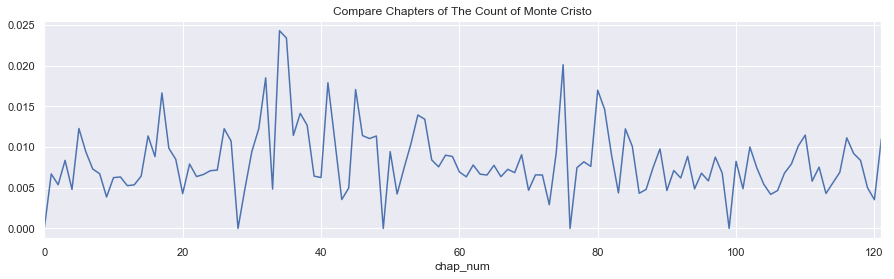

In [33]:
D.tf.plot(figsize=(15,4), title = 'Compare Chapters of The Count of Monte Cristo')

In [45]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [35]:
MC_P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
MC_P.index.names = ['doc_x','doc_y']

In [36]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [37]:
MC_P['euclidean'] = 0
MC_P['euclidean'] = MC_P.apply(euclidean, 1)

In [38]:
MC_PME = MC_P.euclidean.unstack().fillna(0)

In [39]:
MC_PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,112,113,114,115,116,117,118,119,120,121
doc_x,,,,,,,,,,,,,,,,,,,,,
0,1.606819,1.605875,1.607295,1.609218,1.604781,1.606257,1.605214,1.607141,1.607432,1.612218,...,1.604815,1.607592,1.608217,1.604750,1.604433,1.604533,1.605623,1.611331,1.606998,1.603247
1,0.000000,0.130620,0.153634,0.167131,0.120709,0.152232,0.120827,0.146230,0.160652,0.223758,...,0.138365,0.167043,0.173692,0.136394,0.127758,0.130573,0.144072,0.198200,0.159168,0.129106
2,0.000000,0.000000,0.131908,0.141800,0.103940,0.142652,0.119096,0.138468,0.150170,0.217611,...,0.126182,0.157336,0.164798,0.124773,0.117081,0.121024,0.134400,0.190620,0.148011,0.120788
3,0.000000,0.000000,0.000000,0.120359,0.109101,0.158219,0.141030,0.158459,0.157537,0.228146,...,0.142400,0.171460,0.177223,0.141746,0.131183,0.138015,0.149623,0.201726,0.162530,0.139282
4,0.000000,0.000000,0.000000,0.000000,0.127782,0.174741,0.155435,0.169266,0.174344,0.240170,...,0.162760,0.187314,0.193871,0.161971,0.155677,0.158921,0.167369,0.213506,0.176294,0.161134


In [40]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [41]:
MC_P['cosine'] = MC_P.apply(cosine, 1)
MC_PMC = MC_P.cosine.unstack().fillna(0)
MC_PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,112,113,114,115,116,117,118,119,120,121
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.000005,0.000007,0.000006,0.000008,0.000006,0.000008,0.000003,0.000004,0.000006,0.001855,...,0.000007,0.000004,0.000006,0.000004,0.000005,0.000009,0.000007,0.000005,0.000003,0.001216
1,0.000000,0.001734,0.001061,0.001534,0.001253,0.000295,0.001715,0.001479,0.000610,0.000239,...,0.000173,0.000207,0.000141,0.000258,0.000571,0.000484,0.000403,0.000354,0.000380,0.000619
2,0.000000,0.000000,0.002069,0.003049,0.001587,0.000274,0.001132,0.001410,0.000740,0.000186,...,0.000248,0.000264,0.000152,0.000288,0.000516,0.000356,0.000356,0.000371,0.000535,0.000410
3,0.000000,0.000000,0.000000,0.005340,0.002277,0.000219,0.000719,0.000927,0.001249,0.000137,...,0.000277,0.000217,0.000214,0.000269,0.000734,0.000362,0.000379,0.000383,0.000496,0.000305
4,0.000000,0.000000,0.000000,0.000000,0.002707,0.000379,0.001227,0.001592,0.001405,0.000264,...,0.000271,0.000345,0.000217,0.000282,0.000523,0.000358,0.000518,0.000695,0.000891,0.000207


## Cosine Similarity

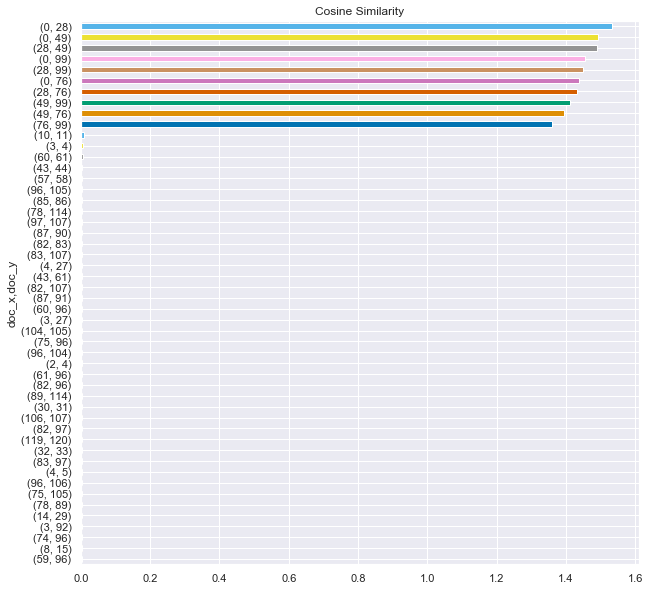

In [42]:
MC_P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', color=sns.color_palette('colorblind'), figsize=(10,10), title = 'Cosine Similarity')

## Compare Euclidean and Cosine Metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


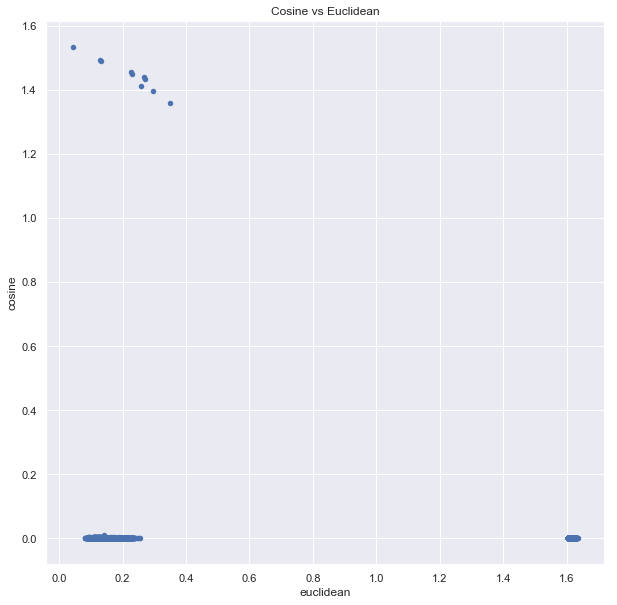

In [43]:
MC_P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10), title='Cosine vs Euclidean')

In [44]:
import matplotlib.pyplot as plt

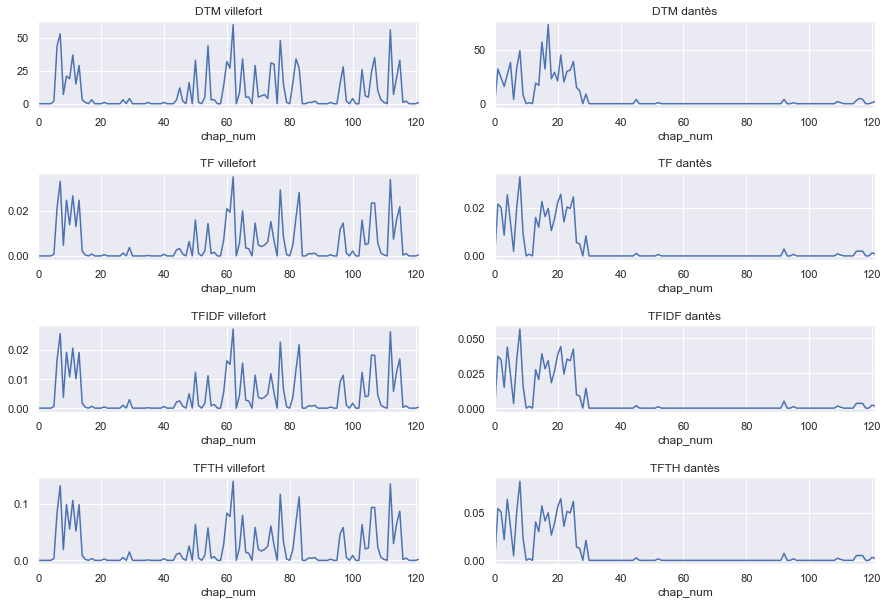

In [46]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('villefort dantès'.split()):
    W = get_term_id(MC_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

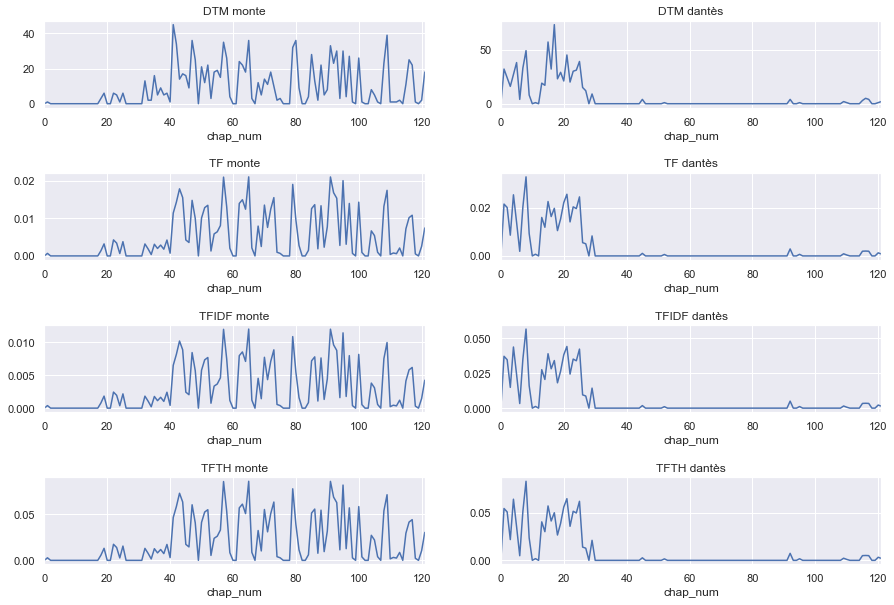

In [47]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('monte dantès'.split()):
    W = get_term_id(MC_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

In [48]:
MC_V.to_csv('The_Cont_of_Monte_Cristo_V.csv', index=False)

## Visualize KDE Plots

In [49]:
MC_K.head()

pos   token_str  punc  num    term_str  \
chap_num para_num sent_num token_num                                           
0        0        0        0          NNP      VOLUME     0    0      volume   
                           1           CD         ONE     0    0         one   
1        0        0        0           NN     Chapter     0    0     chapter   
                  1        0          NNS  Marseilles     0    0  marseilles   
                           2           DT         The     0    0         the   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0            15194  
                           1             9628  
1        0        0        0             2273  
                  1        0             8620  
                           2            14076

In [50]:
lmk = MC_K.copy()

In [51]:
tt = lmk[['term_str','term_id']]
tt.head()

term_str  term_id
chap_num para_num sent_num token_num                     
0        0        0        0              volume    15194
                           1                 one     9628
1        0        0        0             chapter     2273
                  1        0          marseilles     8620
                           2                 the    14076

In [52]:
K = tt.reset_index()

In [53]:
K.rename_axis('offset', inplace=True)

In [54]:
K = K[['term_str','term_id']]
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_str,volume,one,chapter,marseilles,the,arrival,on,the,of,february,the
term_id,15194,9628,2273,8620,14076,812,9626,14076,9577,5407,14076


In [55]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000
kde_samples = 1000

In [56]:
V1 = MC_V[(MC_V[vocab_weight] > MC_V[vocab_weight].quantile(vocab_weight_quantile)) & (MC_V.n >= vocab_min_n)]

In [57]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,15194,3481,14955,389,3478,15117,3209,1952,9058,5869
term_str,volume,dantès,valentine,albert,danglars,villefort,count,caderousse,morrel,franz
n,13,732,643,780,918,1088,1487,419,774,571
p,2.79169e-05,0.00157194,0.00138081,0.00167501,0.00197136,0.00233643,0.00319326,0.000899783,0.00166213,0.0012262
port_stem,volum,dantè,valentin,albert,danglar,villefort,count,caderouss,morrel,franz
stop,0,0,0,0,0,0,0,0,0,0
df,13,37,33,41,62,71,77,23,49,30
tf_sum,2.4845,0.428887,0.365634,0.38709,0.552778,0.672957,0.777293,0.211673,0.380982,0.213473
tf_mean,0.0203648,0.00351547,0.002997,0.00317287,0.00453097,0.00551604,0.00637125,0.00173502,0.0031228,0.00174978
tf_max,0.496103,0.0329741,0.0421614,0.0339298,0.0352299,0.0348227,0.0292615,0.0261776,0.0347118,0.0296321
tfidf_sum,8.02568,0.738236,0.689711,0.608964,0.539811,0.525572,0.516084,0.509534,0.501383,0.432037


In [58]:
TOP_TERMS = MC_V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [60]:
TOP_TERMS

['volume',
 'dantès',
 'valentine',
 'albert',
 'danglars',
 'villefort',
 'count',
 'caderousse',
 'morrel',
 'franz',
 'madame',
 'beauchamp',
 'noirtier',
 'monte',
 'cristo',
 'andrea',
 'edmond',
 'mercédès',
 'four',
 'fernand',
 'abbé',
 'five',
 'bertuccio',
 'avrigny',
 'maximilian',
 'excellency',
 'sire',
 'notary',
 'morcerf',
 'president']

In [61]:
K = K[K.term_id.isin(V1.index)]

In [62]:
K.head(11).T

offset,0,1,3,11,16,17,21,22,24,31,34
term_str,volume,one,marseilles,look,de,la,three,master,pharaon,usual,put
term_id,15194,9628,8620,8324,3525,7913,14169,8653,10272,14924,11147


In [63]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [64]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [65]:
B.head()

,offset,x
term_str,,
abbé,"[28063, 28099, 28262, 41644, 42630, 42657, 427...","[[28063], [28099], [28262], [41644], [42630], ..."
able,"[4105, 14040, 16051, 21028, 24827, 35610, 4738...","[[4105], [14040], [16051], [21028], [24827], [..."
according,"[56, 2760, 4987, 14044, 47640, 93619, 137235, ...","[[56], [2760], [4987], [14044], [47640], [9361..."
account,"[7423, 10520, 16491, 25803, 55615, 61366, 7837...","[[7423], [10520], [16491], [25803], [55615], [..."
accused,"[19915, 19958, 21330, 21348, 22804, 26448, 292...","[[19915], [19958], [21330], [21348], [22804], ..."


In [66]:
from sklearn.neighbors import KernelDensity as KDE
scale_max = K.index.max()
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [67]:
B.head()

,offset,x,kde,scores
term_str,,,,
abbé,"[28063, 28099, 28262, 41644, 42630, 42657, 427...","[[28063], [28099], [28262], [41644], [42630], ...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-29.95244826912036, -29.43224405780608, -28.9..."
able,"[4105, 14040, 16051, 21028, 24827, 35610, 4738...","[[4105], [14040], [16051], [21028], [24827], [...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-14.260069544606427, -14.180535208382517, -14..."
according,"[56, 2760, 4987, 14044, 47640, 93619, 137235, ...","[[56], [2760], [4987], [14044], [47640], [9361...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.514405250794388, -12.474900708648942, -12..."
account,"[7423, 10520, 16491, 25803, 55615, 61366, 7837...","[[7423], [10520], [16491], [25803], [55615], [...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-14.754713552153165, -14.604416702239696, -14..."
accused,"[19915, 19958, 21330, 21348, 22804, 26448, 292...","[[19915], [19958], [21330], [21348], [22804], ...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-19.643855836231232, -19.268528817659046, -18..."


In [68]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

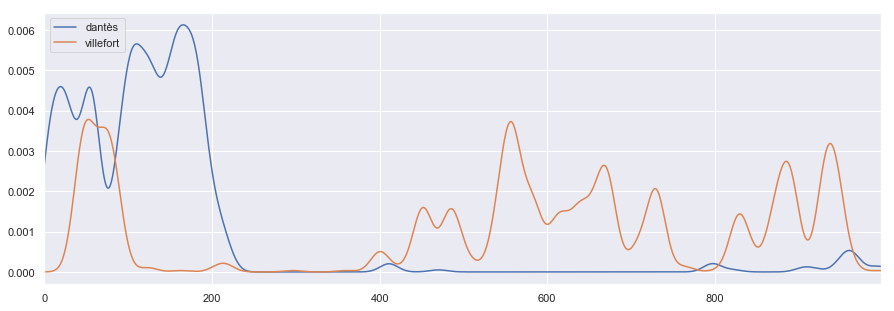

In [69]:
FIG = dict(figsize=(15, 5))
PLOTS.loc['dantès'].plot(**FIG)
PLOTS.loc['villefort'].plot(**FIG)
plt.legend(loc='upper left') 

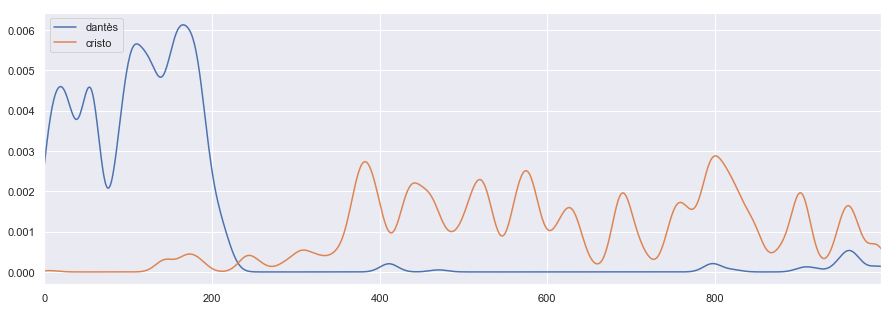

In [70]:
PLOTS.loc['dantès'].plot(**FIG)
PLOTS.loc['cristo'].plot(**FIG)
plt.legend(loc='upper left') 

## Compute TFIDF

In [71]:
WORDS = (MC_K.punc == 0) & (MC_K.num == 0) & MC_K.term_id.isin(MC_V[MC_V.stop==0].index)

In [72]:
BOW = MC_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [73]:
DTM = BOW.unstack().fillna(0)

In [74]:
alpha = .000001 
alpha_sum = alpha * MC_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [75]:
N_docs = DTM.shape[0]
MC_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / MC_V[MC_V.stop==0]['df'])

In [76]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,15703,15704,15705,15706,15707,15708,15709,15710,15711,15712
chap_num,,,,,,,,,,,,,,,,,,,,,
0,3.438596e-06,1.659963e-06,1.500242e-06,2.942459e-06,3.438596e-06,3.438596e-06,3.438596e-06,3.438596e-06,3.438596e-06,3.438596e-06,...,2.446322e-06,3.438596e-06,3.438596e-06,3.438596e-06,1.226106e-06,3.438596e-06,1.259404e-06,2.942459e-06,3.438596e-06,2.942459e-06
1,4.682881e-09,2.260635e-09,2.043118e-09,4.007213e-09,4.682881e-09,4.682881e-09,4.682881e-09,4.682881e-09,4.682881e-09,4.682881e-09,...,3.331544e-09,4.682881e-09,4.682881e-09,4.682881e-09,1.669784e-09,4.682881e-09,1.715131e-09,4.007213e-09,4.682881e-09,4.007213e-09
2,5.833878e-09,2.816272e-09,2.545292e-09,4.992138e-09,5.833878e-09,5.833878e-09,5.833878e-09,5.833878e-09,5.833878e-09,5.833878e-09,...,4.150398e-09,5.833878e-09,5.833878e-09,5.833878e-09,2.080196e-09,5.833878e-09,2.136689e-09,4.992138e-09,5.833878e-09,4.992138e-09
3,3.750367e-09,1.810469e-09,1.636267e-09,3.209246e-09,3.750367e-09,3.750367e-09,3.750367e-09,3.750367e-09,3.750367e-09,3.750367e-09,...,2.668125e-09,3.750367e-09,3.750367e-09,3.750367e-09,1.337275e-09,3.750367e-09,1.373592e-09,3.209246e-09,3.750367e-09,3.209246e-09
4,6.544509e-09,3.159325e-09,2.855337e-09,5.600236e-09,6.544509e-09,6.544509e-09,6.544509e-09,6.544509e-09,6.544509e-09,6.544509e-09,...,4.655963e-09,6.544509e-09,6.544509e-09,6.544509e-09,2.333588e-09,6.544509e-09,2.396962e-09,5.600236e-09,6.544509e-09,5.600236e-09


## Principal Component Analysis

In [77]:
def get_pca(df, k=2):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    X = pd.DataFrame(pca.fit_transform(df))
    X.index = df.index.tolist()
    return X

In [78]:
pca1 = get_pca(TFIDF, k=2)
pca1

,0,1
0,1.535392,-0.025653
1,-0.065915,0.000119
2,-0.065911,0.000021
3,-0.066000,0.001491
4,-0.066215,0.001174
5,-0.065946,0.000536
6,-0.065775,-0.000904
7,-0.065939,-0.000134
8,-0.065932,0.002109
9,-0.065940,-0.000258


In [79]:
X = np.array(pca1)
X

array([[ 1.53539187e+00, -2.56530851e-02],
       [-6.59150693e-02,  1.19021933e-04],
       [-6.59107538e-02,  2.12124624e-05],
       [-6.59998714e-02,  1.49140895e-03],
       [-6.62152386e-02,  1.17430608e-03],
       [-6.59460748e-02,  5.36298870e-04],
       [-6.57745762e-02, -9.03807125e-04],
       [-6.59392055e-02, -1.34459365e-04],
       [-6.59321660e-02,  2.10944578e-03],
       [-6.59398246e-02, -2.58222118e-04],
       [-6.36086000e-02, -2.43817519e-03],
       [-6.59671258e-02, -2.39331283e-03],
       [-6.57669969e-02, -6.50350274e-04],
       [-6.59721627e-02, -1.28553269e-04],
       [-6.59229042e-02, -1.54621010e-04],
       [-6.58334877e-02,  1.00376308e-03],
       [-6.41054026e-02,  8.97327399e-05],
       [-6.58558488e-02,  3.80155312e-04],
       [-6.43449168e-02,  3.13124480e-04],
       [-6.58490720e-02, -3.13741670e-04],
       [-6.58689041e-02, -1.49800908e-04],
       [-6.58687328e-02,  9.58078688e-04],
       [-6.58586167e-02,  6.34633228e-04],
       [-6.

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [81]:
print(pca.components_)

[[1. 0.]
 [0. 1.]]


In [82]:
print(pca.explained_variance_)

[0.10202925 0.00052691]


In [83]:
print(pca.mean_)

[ 3.86758021e-18 -1.79982004e-18]


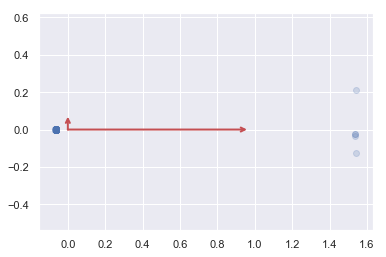

In [84]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Sentiment Analysis

In [85]:
import sqlite3

In [86]:
# Developed in other notebook
lex_db = 'lexicon/lexicons.db'

In [95]:
text_db = 'db/The_Count_of Monte_Cristo.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

emo = 'bing_sentiment'
#emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [96]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [97]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [98]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [99]:
emo_cols = combo.columns

In [100]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'gi_sentiment'],
      dtype='object')

In [101]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [102]:
tokens = tokens.join(combo, on='term_str', how='left')

In [103]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
110       37        0         15           NaN
8         59        0         1            NaN
41        163       0         26           NaN
48        65        1         9            NaN
93        99        4         10          -1.0
78        60        2         7            NaN
59        23        0         16           NaN
30        130       2         2            NaN
84        66        0         2            NaN
34        208       0         8            NaN
Name: bing_sentiment, dtype: float64

In [104]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [105]:
tokens.head(10)

pos   token_str  punc  num    term_str  \
chap_num para_num sent_num token_num                                           
0        0        0        0          NNP      VOLUME     0    0      volume   
                           1           CD         ONE     0    0         one   
1        0        0        0           NN     Chapter     0    0     chapter   
                           1           CD           1     0    1        None   
                  1        0          NNS  Marseilles     0    0  marseilles   
                           2           DT         The     0    0         the   
                           3           NN     Arrival     0    0     arrival   
         1        0        0           IN          On     0    0          on   
                           1           DT         the     0    0         the   
                           2           CD        24th     0    1        None   

                                      term_id  nrc_anger  nrc_anticipation  \
chap_num para_num sent_num token_num                                         
0        0        0        0            15194        0.0               0.0   
                           1             9628        0.0               0.0   
1        0        0        0             2273        0.0               0.0   
                           1               -1        0.0               0.0   
                  1        0             8620        0.0               0.0   
                           2            14076        0.0               0.0   
                           3              812        0.0               0.0   
         1        0        0             9626        0.0               0.0   
                           1            14076        0.0               0.0   
                           2               -1        0.0               0.0   

                                      nrc_disgust  nrc_fear  nrc_joy  \
chap_num para_num sent_num token_num                                   
0        0        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
1        0        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                  1        0                  0.0       0.0      0.0   
                           2                  0.0       0.0      0.0   
                           3                  0.0       0.0      0.0   
         1        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           2                  0.0       0.0      0.0   

                                      nrc_negative  nrc_positive  nrc_sadness  \
chap_num para_num sent_num token_num                                            
0        0        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
1        0        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                  1        0                   0.0           0.0          0.0   
                           2                   0.0           0.0          0.0   
                           3                   0.0           0.0          0.0   
         1        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           2                   0.0           0.0          0.0   

                                      nrc_surprise  nrc_trust  bing_negative  \
chap_num para_num sent_num token_num                                           
0        0        0        0                   0.0        0.0            0.0   
                           1                   0.0        0.0 

In [106]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

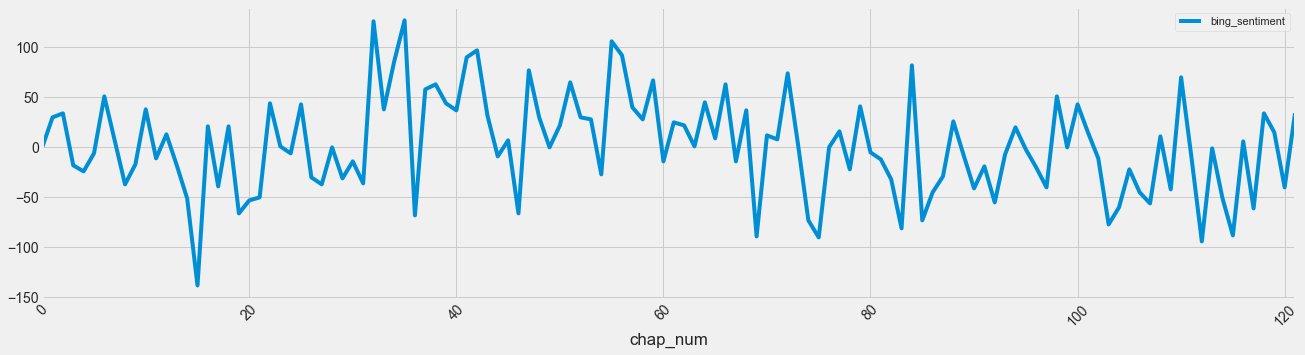

In [107]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

In [108]:
by_chaps= tokens.groupby(CHAPS)[emo_cols].sum()

In [109]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [110]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0                <span class='sent0'>VOLUME</span>
                              1                   <span class='sent0'>ONE</span>
1         0         0         0               <span class='sent0'>Chapter</span>
                              1                     <span class='sent0'>1</span>
                    1         0            <span class='sent0'>Marseilles</span>
Name: html, dtype: object

In [111]:
by_chaps['chaps_str'] = tokens.groupby(CHAPS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_chaps['html_str'] = tokens.groupby(CHAPS).html.apply(lambda x: x.str.cat(sep=' '))

In [112]:
by_chaps[['chaps_str', 'html_str']].head()

,chaps_str,html_str
chap_num,,
0,volume one,<span class='sent0'>VOLUME</span> <span class=...
1,chapter marseilles the arrival on the of febru...,<span class='sent0'>Chapter</span> <span class...
2,chapter father and son we will leave danglars ...,<span class='sent0'>Chapter</span> <span class...
3,chapter the catalans beyond a bare weather wor...,<span class='sent0'>Chapter</span> <span class...
4,chapter conspiracy danglars followed edmond an...,<span class='sent0'>Chapter</span> <span class...


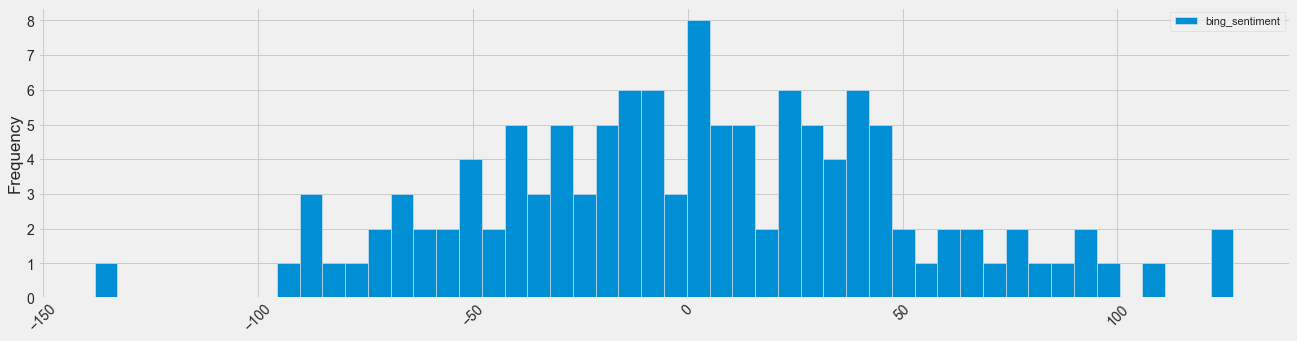

In [113]:
by_chaps[emo].plot.hist(**FIG, bins=50)

### Positive

In [114]:
by_chaps.sort_values(emo, ascending=False)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
35,127.0,chapter the colosseum franz had so managed his...
32,126.0,chapter italy sinbad the sailor towards the be...
55,106.0,chapter robert le diable the pretext of an ope...
42,97.0,chapter the presentation when albert found him...
56,92.0,chapter a flurry in stocks some days after thi...
41,90.0,chapter the breakfast and what sort of persons...
34,86.0,chapter roman bandits the next morning franz w...
84,82.0,chapter the room of the retired baker the even...
47,77.0,chapter unlimited credit about two o clock the...


### Negative

In [115]:
by_chaps.sort_values(emo, ascending=True)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
15,-138.0,chapter number and number dantès passed throug...
112,-94.0,chapter the judge we remember that the abbé bu...
75,-90.0,chapter the promise it was indeed maximilian m...
69,-89.0,chapter the office of the king s attorney let ...
115,-88.0,chapter expiation notwithstanding the density ...
83,-81.0,chapter the accusation m d avrigny soon restor...
103,-77.0,chapter the law we have seen how quietly madem...
85,-73.0,chapter the burglary the day following that on...
74,-73.0,chapter madame de saint méran a gloomy scene h...


### Multinomial Emotions

In [116]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [117]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


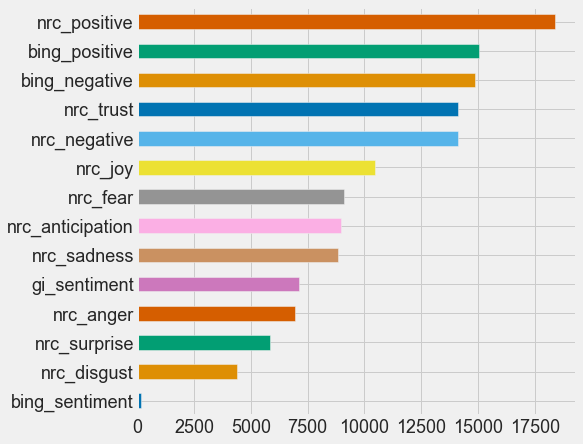

In [118]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18, color=sns.color_palette('colorblind'))

### Visualize KDE for Emotions

In [119]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [120]:
B.head()

,x
emo,
nrc_anger,"[[18], [125], [162], [490], [491], [499], [603..."
nrc_anticipation,"[[39], [57], [66], [239], [313], [344], [377],..."
nrc_disgust,"[[18], [162], [490], [976], [1021], [1117], [1..."
nrc_fear,"[[125], [162], [167], [183], [245], [381], [40..."
nrc_joy,"[[66], [239], [313], [344], [377], [414], [440..."


In [121]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

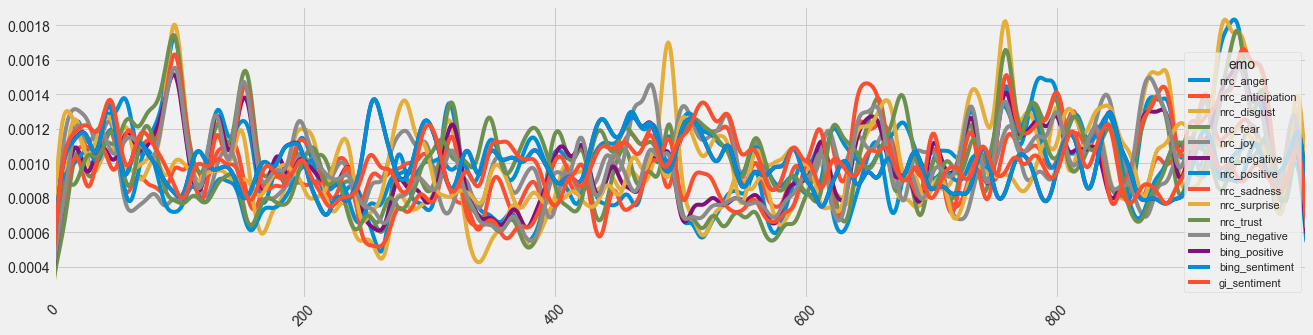

In [122]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

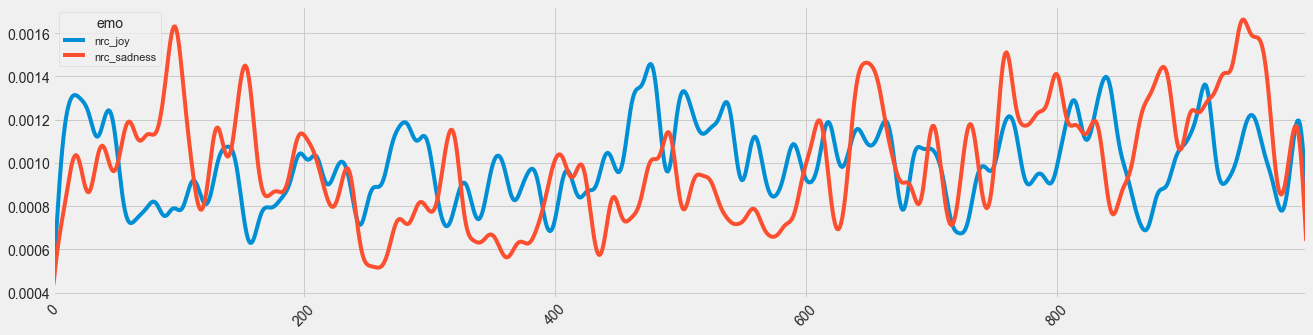

In [123]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

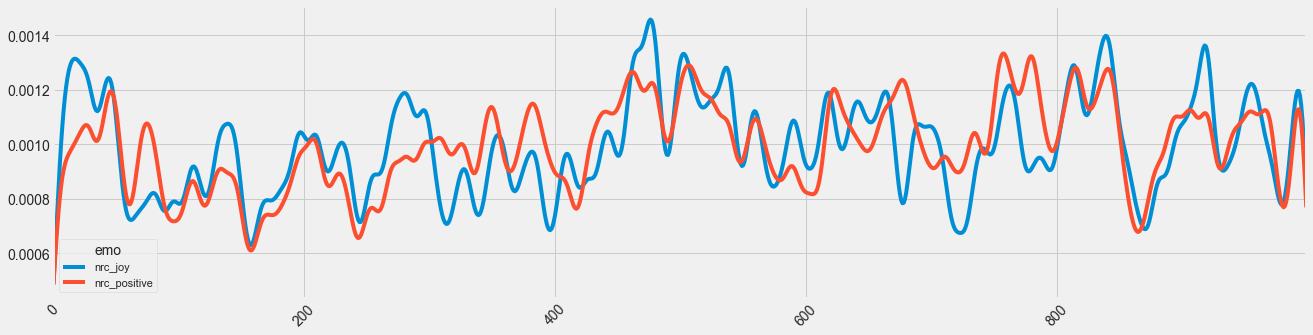

In [124]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

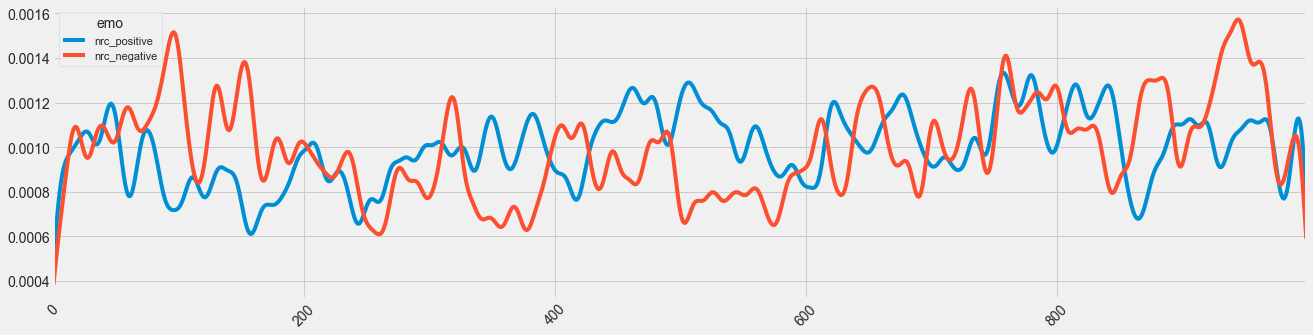

In [125]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

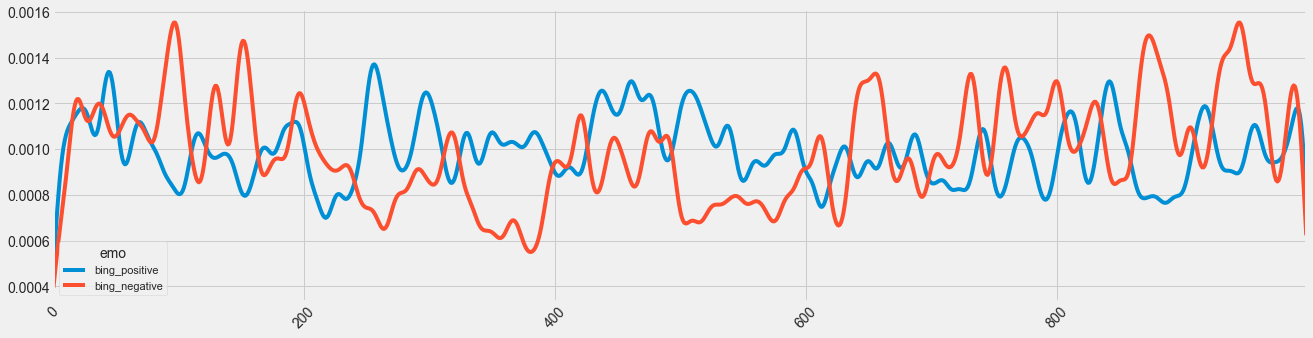

In [126]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)